In [1]:
# Cell 1: Импорты и настройка
import sys
import os
sys.path.append('..')

from src.utils.config import load_config, setup_experiment_env
from src.data.dataloaders import create_dataloaders
from src.models.custom_cnn import ImprovedCarCNN
from src.models.resnet_wrapper import AdvancedResNetWrapper
from src.training.trainer import ModelTrainer
from src.training.metrics import calculate_comprehensive_metrics, print_detailed_metrics
from src.utils.visualization import *

import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

# Автоматическая настройка
config = load_config('../configs/experiment_config.yaml')
setup_experiment_env(config)
device = torch.device(config['experiment']['device'])

print("Environment setup complete!")
print(f"Using device: {device}")

Experiment: car_classification_benchmark
Device: cuda
Number of epochs: 15
Batch size: 32
Environment setup complete!
Using device: cuda


Loading data without albumentations...
Train path: C:\Users\Александр\ml-course\computer-vision\train
Test path: C:\Users\Александр\ml-course\computer-vision\test_upload
Using basic transforms
Number of classes: 4
Class names: ['0', '1', '2', '3']
Training samples: 4504
Validation samples: 1125
Test samples: 6675
Number of classes: 4
Class names: ['0', '1', '2', '3']
Training samples: 4504
Validation samples: 1125
Test samples: 6675


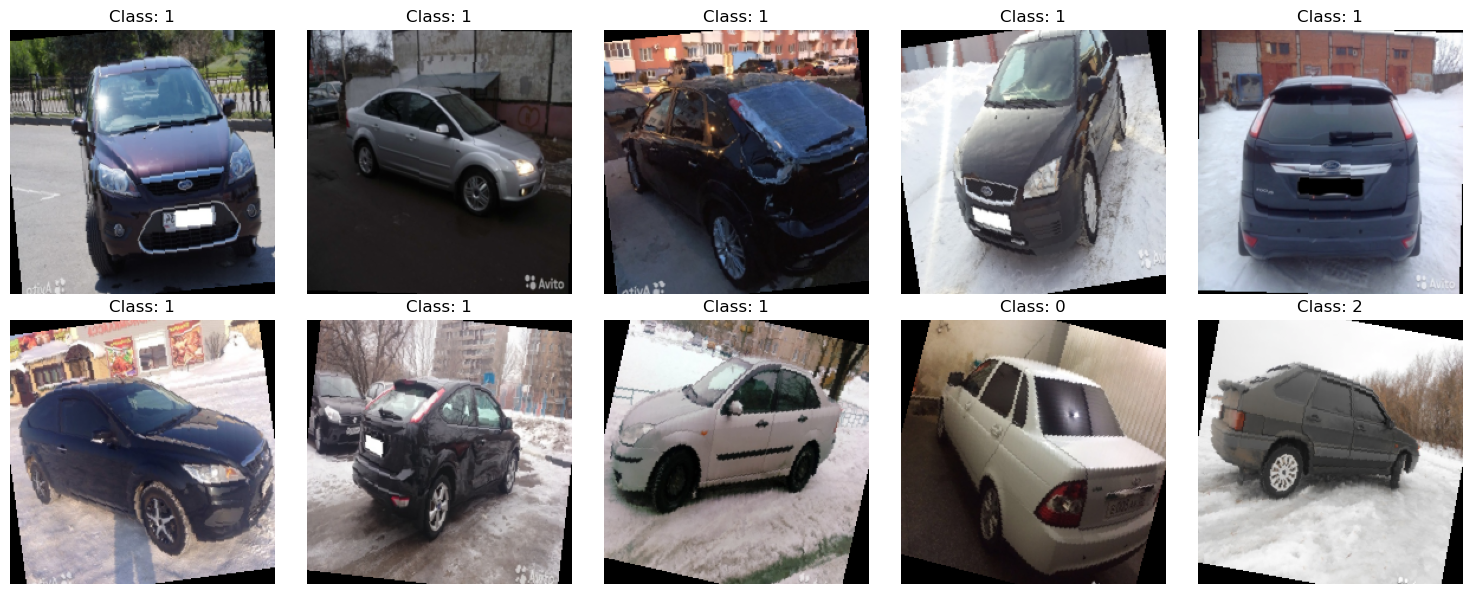

In [2]:
# Cell 2: Загрузка данных БЕЗ albumentations
print("Loading data without albumentations...")
dataloaders = create_dataloaders(config, use_albumentations=False)
num_classes = dataloaders['num_classes']
class_names = dataloaders['class_names']

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Training samples: {len(dataloaders['train'].dataset)}")
print(f"Validation samples: {len(dataloaders['val'].dataset)}")
print(f"Test samples: {len(dataloaders['test'].dataset)}")

# Функция для денормализации изображения
def denormalize(tensor):
    """Денормализация тензора для визуализации"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    return torch.clamp(tensor, 0, 1)

# Визуализация примеров данных
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    image, label = dataloaders['train'].dataset[i]
    
    # Денормализация
    image_denorm = denormalize(image)
    image_np = image_denorm.numpy().transpose((1, 2, 0))
    
    axes[i//5, i%5].imshow(image_np)
    axes[i//5, i%5].set_title(f'Class: {class_names[label]}')
    axes[i//5, i%5].axis('off')

plt.tight_layout()
plt.show()


🚀 Testing resnet18...
Model device: cuda:0
Data device: cuda
✅ resnet18 - Accuracy: 0.2391, F1: 0.2373

🚀 Testing custom_cnn...
Model device: cuda:0
Data device: cuda
✅ custom_cnn - Accuracy: 0.2684, F1: 0.1136


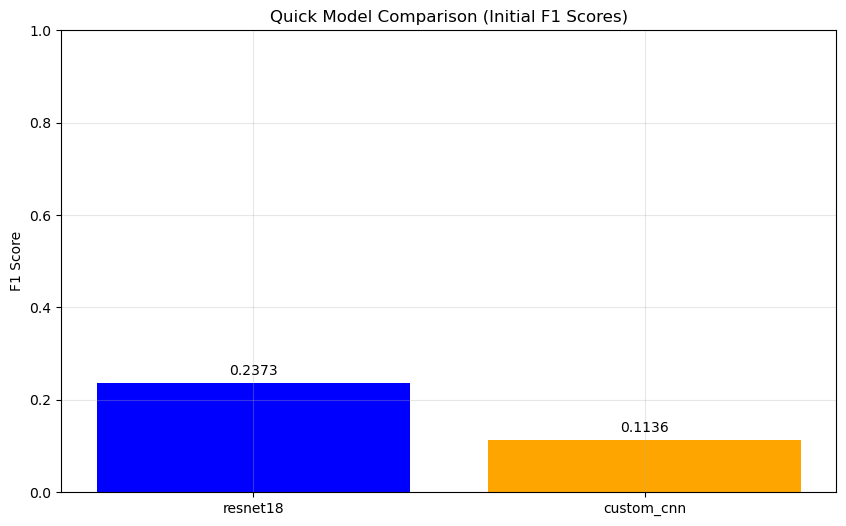

In [4]:
# Cell 3: Быстрое сравнение моделей (ПОЛНОСТЬЮ ИСПРАВЛЕННАЯ ВЕРСИЯ)
models_to_test = ['resnet18', 'custom_cnn']
results = {}

def test_model_simple(model, dataloader, device, class_names):
    """Простая функция тестирования модели"""
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            # Перенос данных на устройство
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    accuracy = correct / total
    
    # Вычисляем F1 score
    from sklearn.metrics import f1_score
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1_weighted': f1,
        'predictions': all_predictions,
        'targets': all_targets
    }

for model_name in models_to_test:
    print(f"\n🚀 Testing {model_name}...")
    
    try:
        # Создание модели
        if model_name == 'custom_cnn':
            model = ImprovedCarCNN(num_classes)
        else:
            wrapper = AdvancedResNetWrapper(model_name, num_classes)
            model = wrapper.get_model()
        
        # ВАЖНО: Перенос модели на устройство ДО оценки
        model = model.to(device)
        print(f"Model device: {next(model.parameters()).device}")
        print(f"Data device: {device}")
        
        # Простая оценка
        metrics = test_model_simple(model, dataloaders['val'], device, class_names)
        results[model_name] = metrics
        
        print(f"✅ {model_name} - Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1_weighted']:.4f}")
        
    except Exception as e:
        print(f"❌ Error testing {model_name}: {e}")
        import traceback
        traceback.print_exc()

# Визуализация быстрого сравнения
if results:
    model_names = list(results.keys())
    f1_scores = [results[m]['f1_weighted'] for m in model_names]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, f1_scores, color=['blue', 'orange'])
    plt.title('Quick Model Comparison (Initial F1 Scores)')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)

    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{score:.4f}', ha='center', va='bottom')

    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("❌ No models were successfully tested")

🎯 Training the best model...
Selected model: resnet18


D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model device: cuda:0
Starting training on cuda
Number of epochs: 15
Model parameters: 11,707,972
Model will be saved to: ../checkpoints/best_resnet18.pth

Epoch 1/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  7.94it/s, Loss=0.3566, LR=0.001000]


Train Loss: 0.8030
Val Loss: 0.3516
Val F1: 0.8696
Val Accuracy: 0.8738
New best model saved! F1: 0.8696

Epoch 2/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  8.03it/s, Loss=0.2581, LR=0.000989]


Train Loss: 0.3215
Val Loss: 0.2818
Val F1: 0.9001
Val Accuracy: 0.8996
New best model saved! F1: 0.9001

Epoch 3/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  8.01it/s, Loss=0.1596, LR=0.000957]


Train Loss: 0.2415
Val Loss: 0.6307
Val F1: 0.7648
Val Accuracy: 0.7751

Epoch 4/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  7.89it/s, Loss=0.0505, LR=0.000905]


Train Loss: 0.1952
Val Loss: 0.1621
Val F1: 0.9396
Val Accuracy: 0.9396
New best model saved! F1: 0.9396

Epoch 5/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  7.98it/s, Loss=0.0922, LR=0.000835]


Train Loss: 0.1624
Val Loss: 0.4383
Val F1: 0.8811
Val Accuracy: 0.8800

Epoch 6/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  7.97it/s, Loss=0.0352, LR=0.000750]


Train Loss: 0.1457
Val Loss: 0.3587
Val F1: 0.8862
Val Accuracy: 0.8853

Epoch 7/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  7.93it/s, Loss=0.2456, LR=0.000655]


Train Loss: 0.1156
Val Loss: 0.1068
Val F1: 0.9593
Val Accuracy: 0.9591
New best model saved! F1: 0.9593

Epoch 8/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  8.02it/s, Loss=0.0143, LR=0.000552]


Train Loss: 0.0840
Val Loss: 0.1440
Val F1: 0.9602
Val Accuracy: 0.9600
New best model saved! F1: 0.9602

Epoch 9/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  8.01it/s, Loss=0.0075, LR=0.000448]


Train Loss: 0.0608
Val Loss: 0.0700
Val F1: 0.9760
Val Accuracy: 0.9760
New best model saved! F1: 0.9760

Epoch 10/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  7.99it/s, Loss=0.0338, LR=0.000345]


Train Loss: 0.0402
Val Loss: 0.1362
Val F1: 0.9607
Val Accuracy: 0.9609

Epoch 11/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  7.93it/s, Loss=0.0072, LR=0.000250]


Train Loss: 0.0282
Val Loss: 0.0952
Val F1: 0.9741
Val Accuracy: 0.9742

Epoch 12/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  7.99it/s, Loss=0.0018, LR=0.000165]


Train Loss: 0.0198
Val Loss: 0.0608
Val F1: 0.9840
Val Accuracy: 0.9840
New best model saved! F1: 0.9840

Epoch 13/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  8.02it/s, Loss=0.0028, LR=0.000095]


Train Loss: 0.0154
Val Loss: 0.0688
Val F1: 0.9742
Val Accuracy: 0.9742

Epoch 14/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  8.01it/s, Loss=0.0010, LR=0.000043]


Train Loss: 0.0126
Val Loss: 0.0672
Val F1: 0.9804
Val Accuracy: 0.9804

Epoch 15/15
--------------------------------------------------


Training: 100%|████████████████████████████████████████████| 141/141 [00:17<00:00,  8.00it/s, Loss=0.0041, LR=0.000011]


Train Loss: 0.0085
Val Loss: 0.0565
Val F1: 0.9786
Val Accuracy: 0.9787


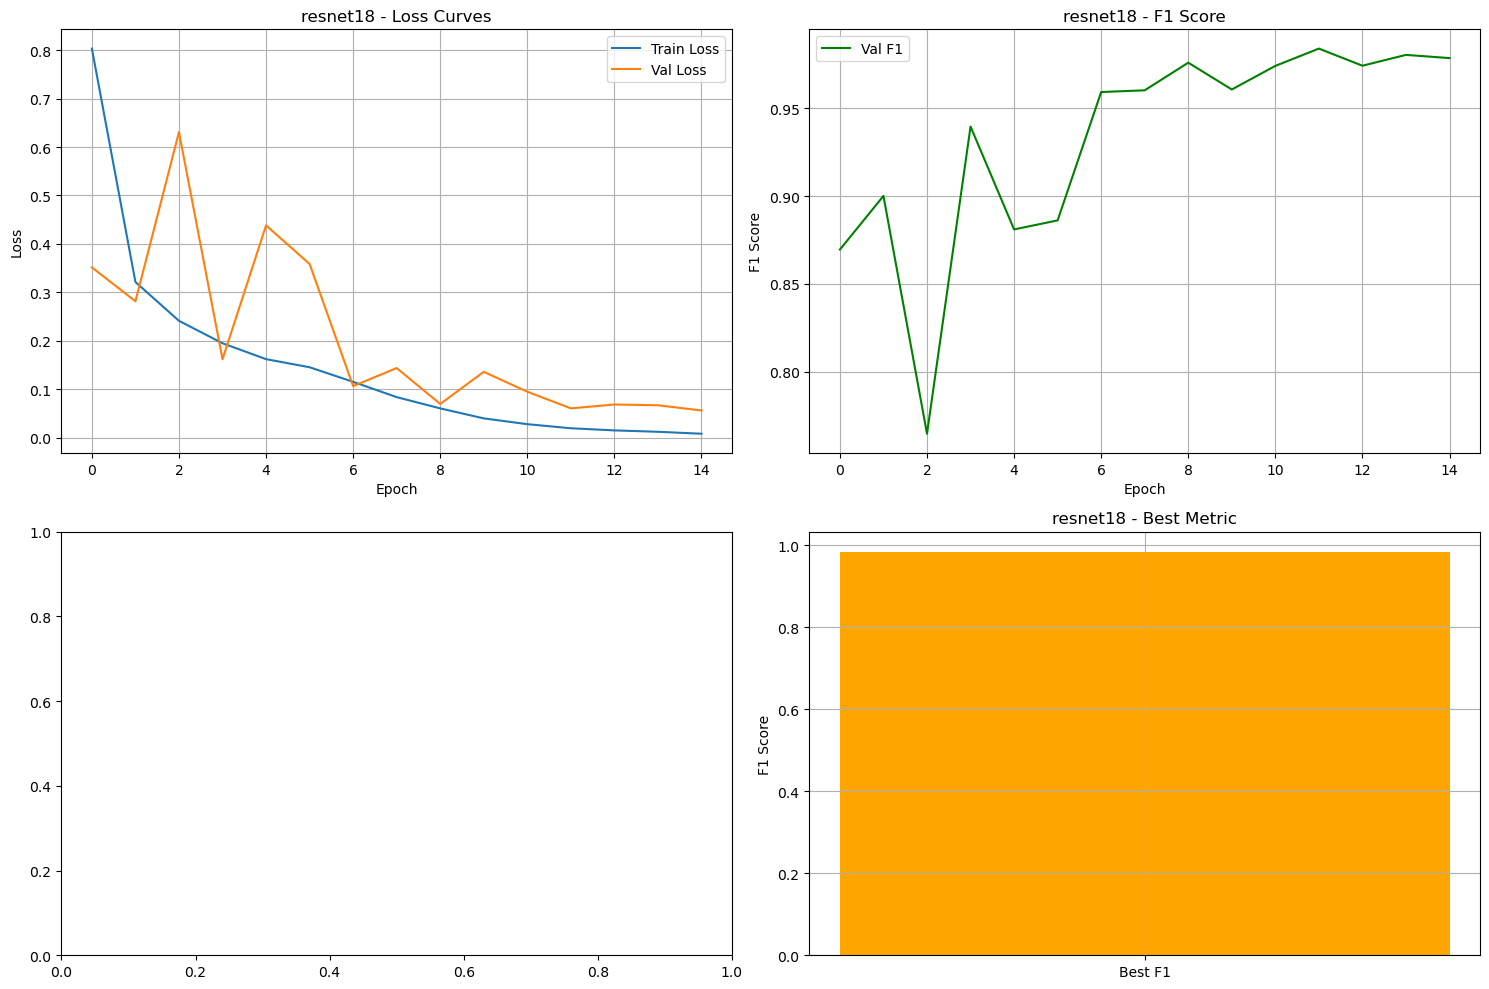

In [5]:
# Cell 4: Полное обучение лучшей модели
print("🎯 Training the best model...")

# Выбор модели на основе быстрого сравнения
best_model_name = max(results, key=lambda x: results[x]['f1_weighted'])
print(f"Selected model: {best_model_name}")

if best_model_name == 'custom_cnn':
    model = ImprovedCarCNN(num_classes)
else:
    wrapper = AdvancedResNetWrapper(best_model_name, num_classes)
    model = wrapper.get_model()

# ВАЖНО: Убедимся что модель на правильном устройстве
model = model.to(device)
print(f"Model device: {next(model.parameters()).device}")

# Обучение
trainer = ModelTrainer(model, config)
training_results = trainer.train(
    dataloaders['train'],
    dataloaders['val'],
    save_path=f"../checkpoints/best_{best_model_name}.pth"
)

# Визуализация результатов обучения
fig = plot_training_history(training_results, best_model_name)
plt.show()

📊 Detailed evaluation of the best model...

DETAILED MODEL METRICS
Loss: 0.0633
Accuracy: 0.9796
F1 Score (Weighted): 0.9795
F1 Score (Macro): 0.9760
Precision: 0.9796
Recall: 0.9796
Min Class Accuracy: 0.9576
Max Class Accuracy: 0.9901

Per-Class Accuracy:
  0: 0.9710
  1: 0.9848
  2: 0.9901
  3: 0.9576


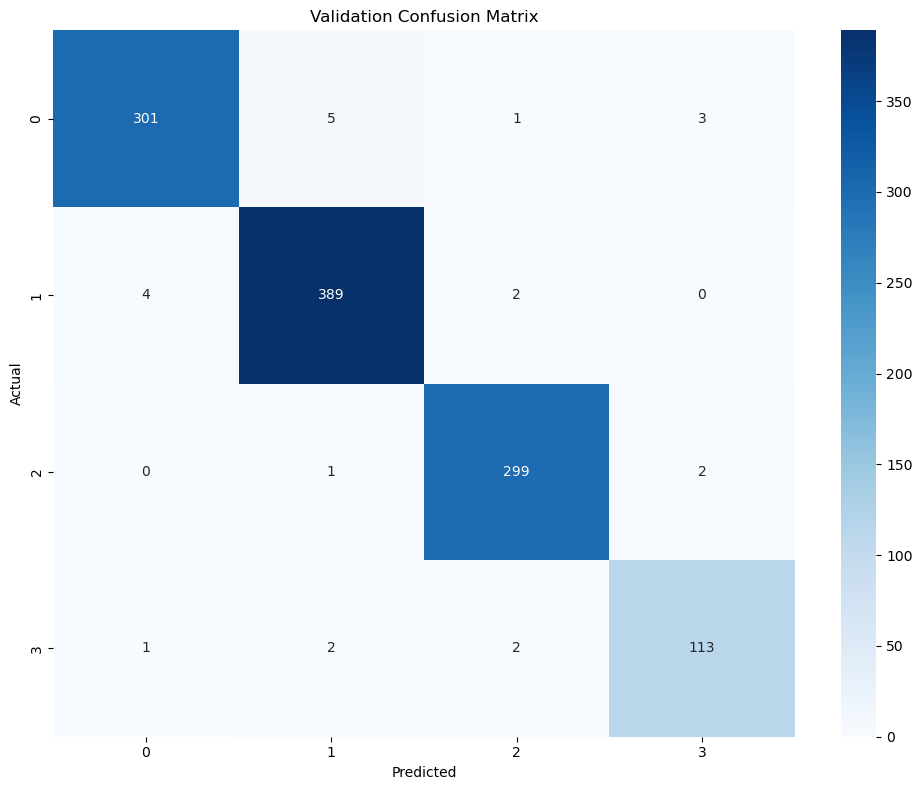

✅ Best model evaluation completed!
   Final Validation Accuracy: 0.9796
   Final Validation F1: 0.9795


In [6]:
# Cell 5: Детальная оценка лучшей модели
print("📊 Detailed evaluation of the best model...")

# Загрузка лучших весов
model.load_state_dict(torch.load(f"../checkpoints/best_{best_model_name}.pth", map_location=device))

# Убедимся что модель на правильном устройстве
model = model.to(device)
model.eval()

# Comprehensive метрики
metrics, predictions = calculate_comprehensive_metrics(
    model, dataloaders['val'], device, trainer.criterion
)

print_detailed_metrics(metrics, class_names)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(
    [label for _, label in dataloaders['val'].dataset],
    predictions[:len(dataloaders['val'].dataset)]
)

cm_fig = plot_confusion_matrix(cm, class_names, 'Validation Confusion Matrix')
plt.show()

print(f"✅ Best model evaluation completed!")
print(f"   Final Validation Accuracy: {metrics['accuracy']:.4f}")
print(f"   Final Validation F1: {metrics['f1_weighted']:.4f}")

🔮 Making test predictions...

📊 Test predictions distribution:
  0:  1775 samples ( 26.59%)
  1:  1847 samples ( 27.67%)
  2:  2001 samples ( 29.98%)
  3:  1052 samples ( 15.76%)
✅ Predictions saved! Total: 6675


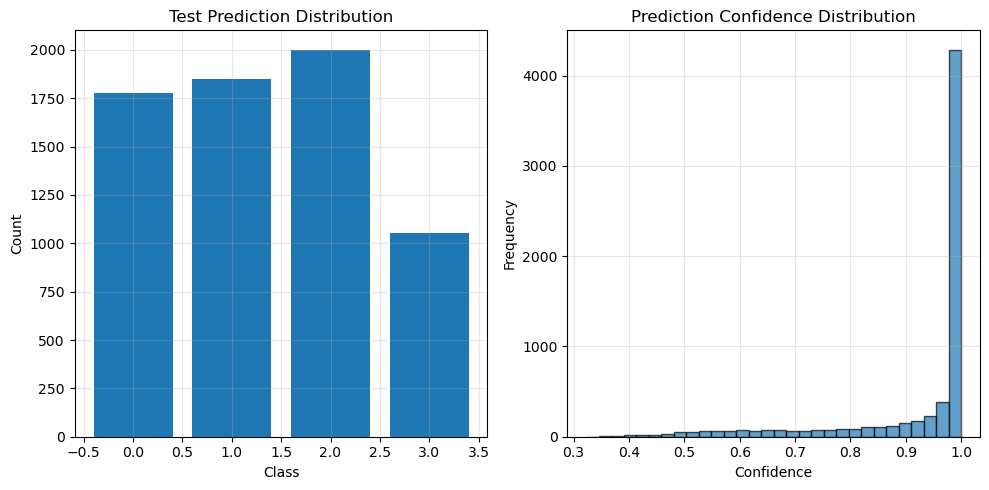

In [7]:
# Cell 6: Предсказания на тестовых данных
print("🔮 Making test predictions...")

test_predictions = []
test_probabilities = []
model.eval()

with torch.no_grad():
    for images, _ in dataloaders['test']:
        images = images.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        test_predictions.extend(preds.cpu().numpy())
        test_probabilities.extend(probabilities.cpu().numpy())

# Анализ распределения
from collections import Counter
class_distribution = Counter(test_predictions)
print("\n📊 Test predictions distribution:")
for cls, count in sorted(class_distribution.items()):
    class_name = class_names[cls] if cls < len(class_names) else f"Class {cls}"
    percentage = (count / len(test_predictions)) * 100
    print(f"  {class_name}: {count:5d} samples ({percentage:6.2f}%)")

# Сохранение предсказаний
with open('../final_predictions.txt', 'w') as f:
    for pred in test_predictions:
        f.write(f"{pred}\n")

print(f"✅ Predictions saved! Total: {len(test_predictions)}")

# Визуализация распределения
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Test Prediction Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
confidences = [prob[pred] for pred, prob in zip(test_predictions, test_probabilities)]
plt.hist(confidences, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

🖼️ Visualizing sample predictions...


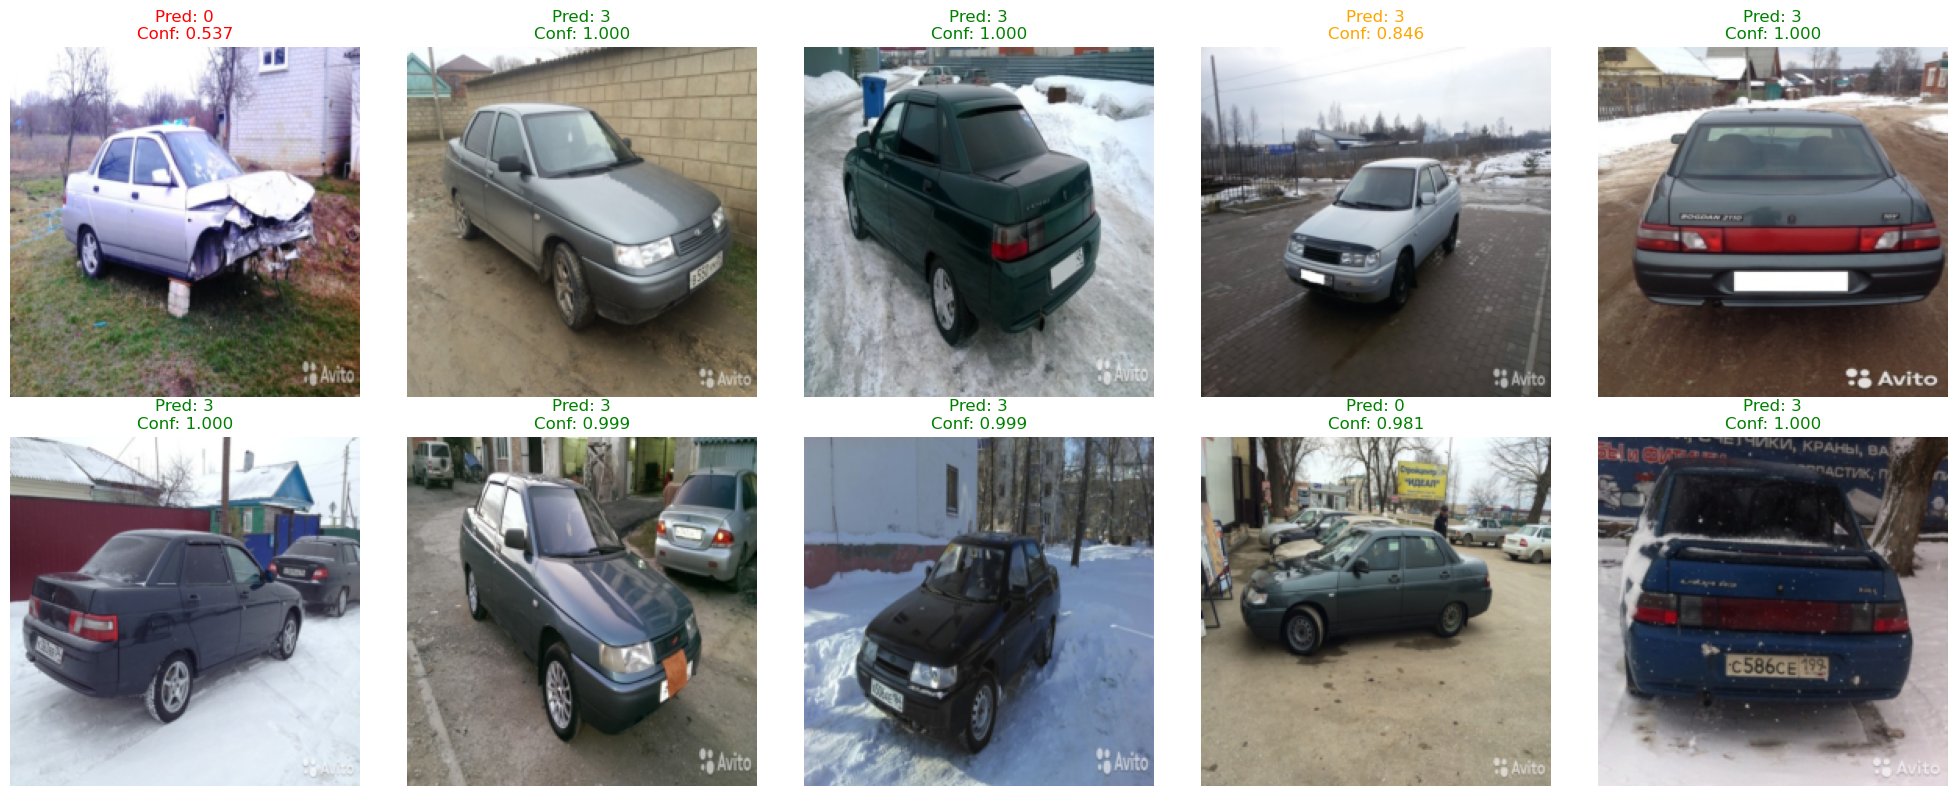

🎉 All tasks completed successfully!


In [8]:
# Cell 7: Визуализация примеров предсказаний
print("🖼️ Visualizing sample predictions...")

# Берем несколько тестовых изображений
sample_images = []
sample_predictions = []
sample_confidences = []

with torch.no_grad():
    for i, (images, _) in enumerate(dataloaders['test']):
        if len(sample_images) >= 10:
            break
        images = images.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, preds = torch.max(probabilities, 1)
        
        for j in range(min(images.size(0), 10 - len(sample_images))):
            sample_images.append(images[j].cpu())
            sample_predictions.append(preds[j].item())
            sample_confidences.append(confidence[j].item())

# Визуализация
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for i in range(10):
    image = sample_images[i]
    pred = sample_predictions[i]
    conf = sample_confidences[i]
    
    # Денормализация
    image_denorm = denormalize(image)
    image_np = image_denorm.numpy().transpose((1, 2, 0))
    
    axes[i].imshow(image_np)
    color = 'green' if conf > 0.9 else 'orange' if conf > 0.7 else 'red'
    axes[i].set_title(f'Pred: {class_names[pred]}\nConf: {conf:.3f}', color=color)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('../results/sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("🎉 All tasks completed successfully!")